In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
import re
import os

import warnings
warnings.simplefilter(action='ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from classifier import Classifier
from constants import *

In [2]:
csvs = sorted(os.listdir(INPUTS_PATH))
csvs

['2014-final.xlsx - Sheet1.csv',
 '2015-final.xlsx - Sheet1.csv',
 '2016-final.xlsx - Total counts.csv',
 '2017-final.xlsx - 2017 LIS phytoplankton count.csv',
 '2018-Final Report Data.xlsx - 2018 LIS phytoplankton count.csv',
 'LIS_2019-Phytoplankton_Final Report Data.xlsx - 2019 LIS phytoplankton count.csv',
 'LIS_2020-Phytoplankton_Final Report Data.xlsx - 2020 LIS phytoplankton count.csv',
 'LIS_2021-Phytoplankton_Final Report Data.xlsx - 2021 LIS phytoplankton count.csv']

In [3]:
def percentages(df, column):
    df = df.groupby([column], as_index=False)['Totals'].sum()
    df['Percentages'] = round(((df['Totals'] / df['Totals'].sum()) * 100), 1)
    df = df.loc[(df[column] != "") & (df['Totals'] != 0)]
    return df

## 1. What fraction of the total cell number are mixotrophs and what fraction are phytoplankton (strict phototrophs)? 
### For this question, we could also aggregate the data by adding all the surface samples together on a given sampling day and comparing that to the bottom samples.  Or we could see if the fraction of mixoplankton changes as we go from West to East (stations A to K), because there is a big decrease in the amount of nutrients like nitrogen that are added to the Sound as you get farther East (away from NYC), so there might be more of a need for mixoplankton to get their nitrogen by eating as you go to the East.

In [6]:
def trophic_strategy_per_station(csv_name):
    # Get year
    year = re.search(r'\b(\d{4})\b', csv_name).group(1) if re.search(r'\b(\d{4})\b', csv_name) else 'Year not found'

    # Clean data
    classified = Classifier(csv_name)
    by_station_SB = classified.add_multiheader(classified.all_classified)
    removed_columns = by_station_SB.loc[:, by_station_SB.columns.get_level_values(2).isin(['Status', 'Phylum', 'Genus', 'Species'])].copy()
    removed_columns.columns = removed_columns.columns.get_level_values(2)
    other_columns = by_station_SB.loc[:, ~by_station_SB.columns.get_level_values(2).isin(['Status', 'Phylum', 'Genus', 'Species', 'Totals'])]
    other_columns.columns = other_columns.columns.get_level_values(1)
    other_columns = other_columns.groupby(other_columns.columns.str[:3], axis=1).sum()
    by_station_SB = pd.concat([removed_columns, other_columns ], axis=1)
    by_station_SB.loc[by_station_SB['Genus']=='Protoperidinium', 'Status'] = 'Protozooplankton'
    by_station_SB = by_station_SB.replace(['No', 'Yes'], ['Phytoplankton', 'Mixoplankton']).drop(['Phylum', 'Genus', 'Species'], axis=1).replace(['No', 'Yes'], ['Phytoplankton', 'Mixoplankton']).groupby('Status').sum()
    by_station_SB.index.name = None
    by_station_SB = by_station_SB.transpose().reset_index().rename(columns={"index": "Station"})
    by_station_SB['Totals'] = by_station_SB[['Mixoplankton', "Phytoplankton", "Protozooplankton"]].sum(axis=1)
    by_station_SB[['Mixoplankton %', "Phytoplankton %", "Protozooplankton %"]] = by_station_SB[['Mixoplankton', "Phytoplankton", "Protozooplankton"]].div(by_station_SB[['Mixoplankton', "Phytoplankton", "Protozooplankton"]].sum(axis=1), axis=0) * 100
        
    # plot bars in stack manner
    ax = by_station_SB.plot(kind='bar', x='Station', y=['Mixoplankton %', 'Phytoplankton %', 'Protozooplankton %'], stacked=True, figsize=(15, 7), xlabel="Stations", ylabel="Trophic Strategy Percentages", legend=True, title=f"Trophic Strategy per Station (S/B) in LIS in {year}", edgecolor='black')
    for container in ax.containers:
        ax.bar_label(container, labels=[f'{bar.get_height():.1f}%' if bar.get_height() > 0 else '' for bar in container], label_type='center', fmt='%.1f%%', color='black')
    ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)
    ax.set_yticklabels([f'{int(tick)}%' for tick in ax.get_yticks()])
    plt.xticks(rotation=0)
    
    plt.show()
    display(by_station_SB)

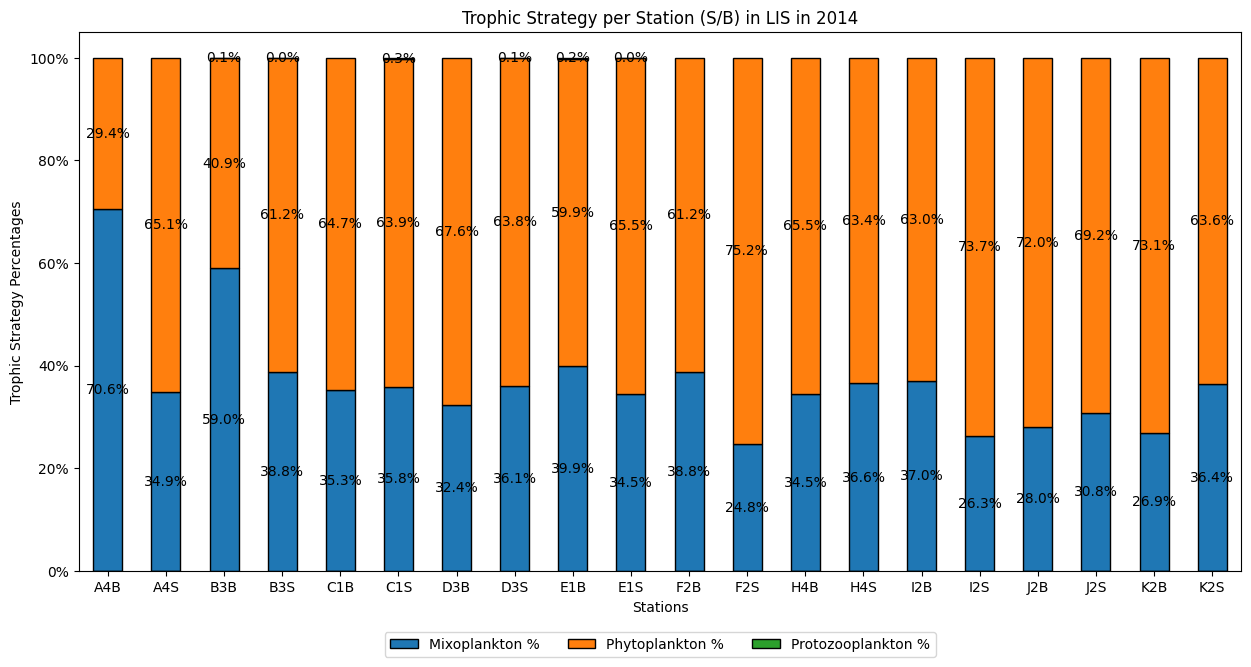

,Station,Mixoplankton,Phytoplankton,Protozooplankton,Totals,Mixoplankton %,Phytoplankton %,Protozooplankton %
0,A4B,944504,394196,0,1338700,70.553821,29.446179,0.000000
1,A4S,4902692,9157664,0,14060356,34.868904,65.131096,0.000000
2,B3B,665808,461516,1452,1128776,58.984954,40.886411,0.128635
3,B3S,3770712,5951176,2904,9724792,38.774217,61.195921,0.029862
4,C1B,459008,843040,0,1302048,35.252771,64.747229,0.000000
5,C1S,2883408,5140696,22000,8046104,35.836077,63.890499,0.273424
6,D3B,265452,554180,0,819632,32.386730,67.613270,0.000000
7,D3S,3500860,6183892,8800,9693552,36.115348,63.793870,0.090782
8,E1B,341704,513040,1452,856196,39.909553,59.920859,0.169587
9,E1S,2406140,4570148,1452,6977740,34.483085,65.496106,0.020809


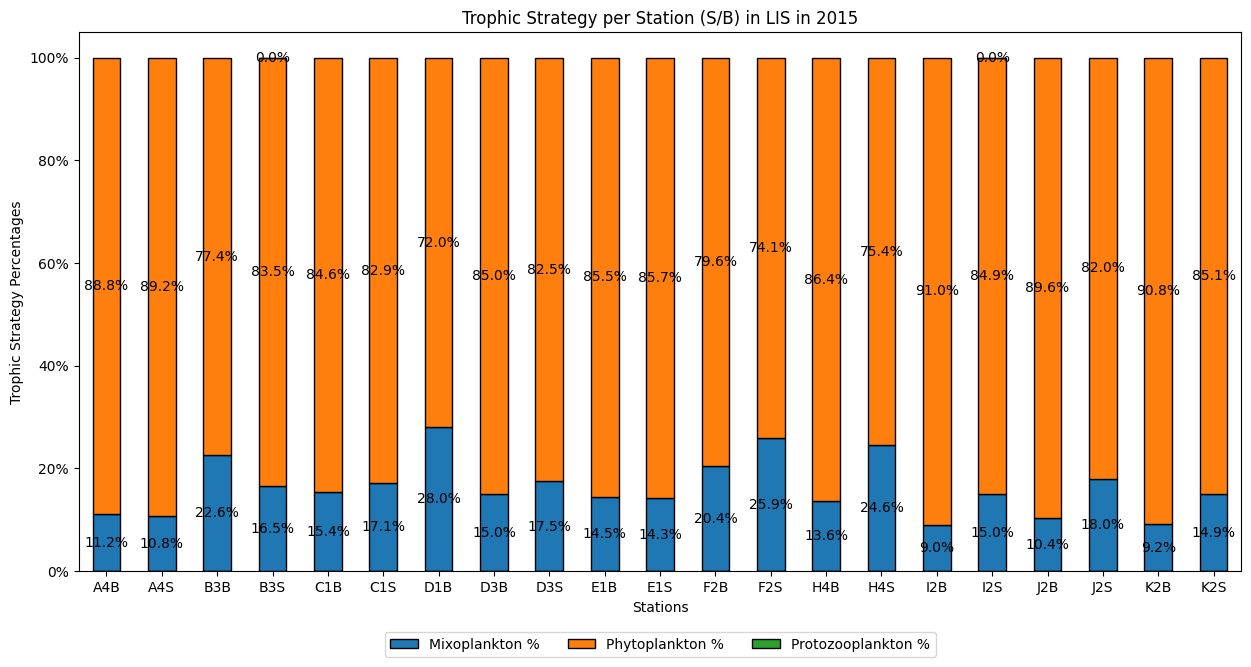

,Station,Mixoplankton,Phytoplankton,Protozooplankton,Totals,Mixoplankton %,Phytoplankton %,Protozooplankton %
0,A4B,1246652,9926180,0,11172832,11.157887,88.842113,0.000000
1,A4S,1488652,12306451,0,13795103,10.791163,89.208837,0.000000
2,B3B,1931160,6614740,0,8545900,22.597503,77.402497,0.000000
3,B3S,1883156,9534363,4400,11421919,16.487212,83.474266,0.038522
4,C1B,1094412,6027648,0,7122060,15.366509,84.633491,0.000000
5,C1S,1845052,8931692,0,10776744,17.120681,82.879319,0.000000
6,D1B,88000,225852,0,313852,28.038693,71.961307,0.000000
7,D3B,975172,5537621,0,6512793,14.973177,85.026823,0.000000
8,D3S,1403600,6637840,0,8041440,17.454585,82.545415,0.000000
9,E1B,818092,4828942,0,5647034,14.487110,85.512890,0.000000


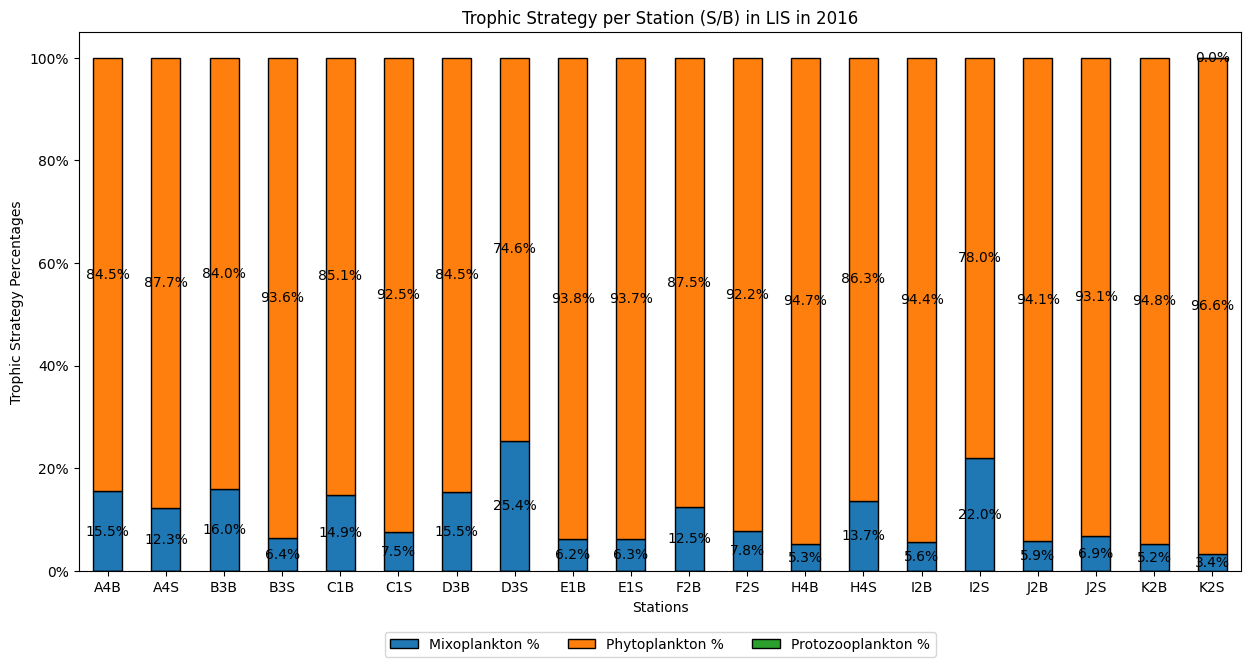

,Station,Mixoplankton,Phytoplankton,Protozooplankton,Totals,Mixoplankton %,Phytoplankton %,Protozooplankton %
0,A4B,770704,4199360,0,4970064,15.506923,84.493077,0.000000
1,A4S,699512,4965708,0,5665220,12.347482,87.652518,0.000000
2,B3B,588060,3085280,0,3673340,16.008864,83.991136,0.000000
3,B3S,699512,10162108,0,10861620,6.440218,93.559782,0.000000
4,C1B,536756,3067812,0,3604568,14.890994,85.109006,0.000000
5,C1S,722964,8885976,0,9608940,7.523868,92.476132,0.000000
6,D3B,456060,2489872,0,2945932,15.481009,84.518991,0.000000
7,D3S,928224,2723160,0,3651384,25.421155,74.578845,0.000000
8,E1B,140756,2137194,0,2277950,6.179065,93.820935,0.000000
9,E1S,134816,2016168,0,2150984,6.267643,93.732357,0.000000


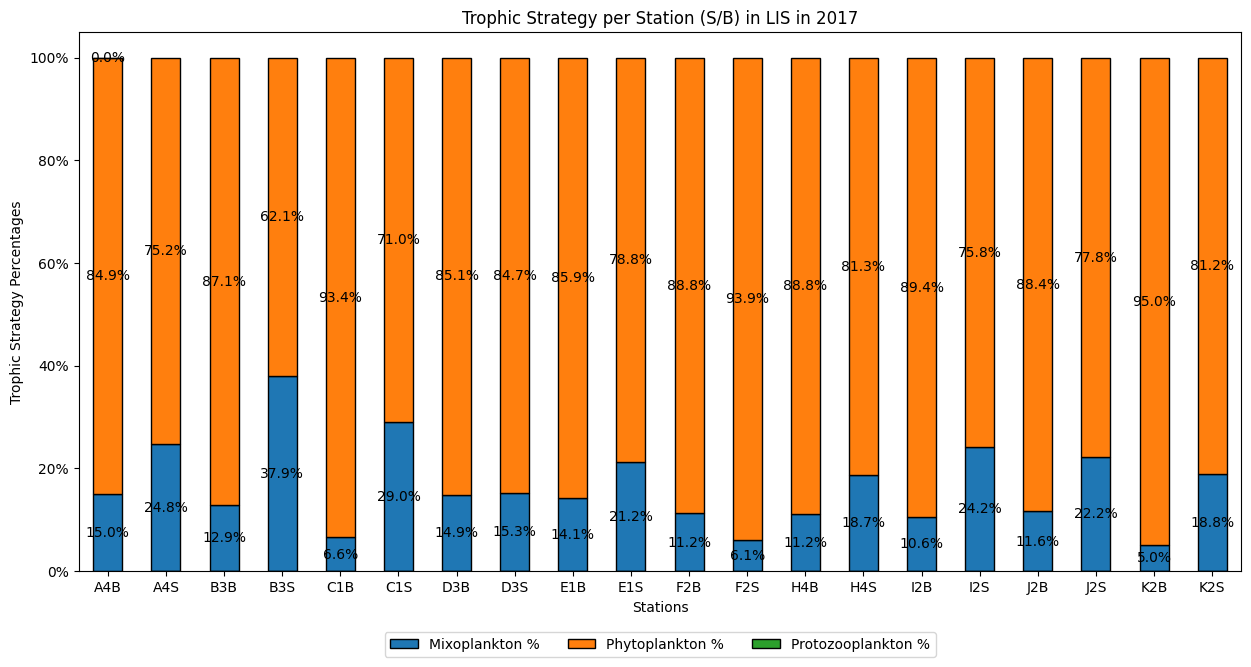

,Station,Mixoplankton,Phytoplankton,Protozooplankton,Totals,Mixoplankton %,Phytoplankton %,Protozooplankton %
0,A4B,1149808,6497524,1452,7648784,15.032559,84.948457,0.018983
1,A4S,2377408,7218992,0,9596400,24.773957,75.226043,0.000000
2,B3B,838112,5679652,0,6517764,12.858888,87.141112,0.000000
3,B3S,3431164,5622276,0,9053440,37.899009,62.100991,0.000000
4,C1B,386452,5510340,0,5896792,6.553597,93.446403,0.000000
5,C1S,1709268,4174852,0,5884120,29.048830,70.951170,0.000000
6,D3B,987008,5649556,0,6636564,14.872274,85.127726,0.000000
7,D3S,1013408,5631472,0,6644880,15.250960,84.749040,0.000000
8,E1B,776512,4716668,0,5493180,14.135929,85.864071,0.000000
9,E1S,1156364,4291496,0,5447860,21.226023,78.773977,0.000000


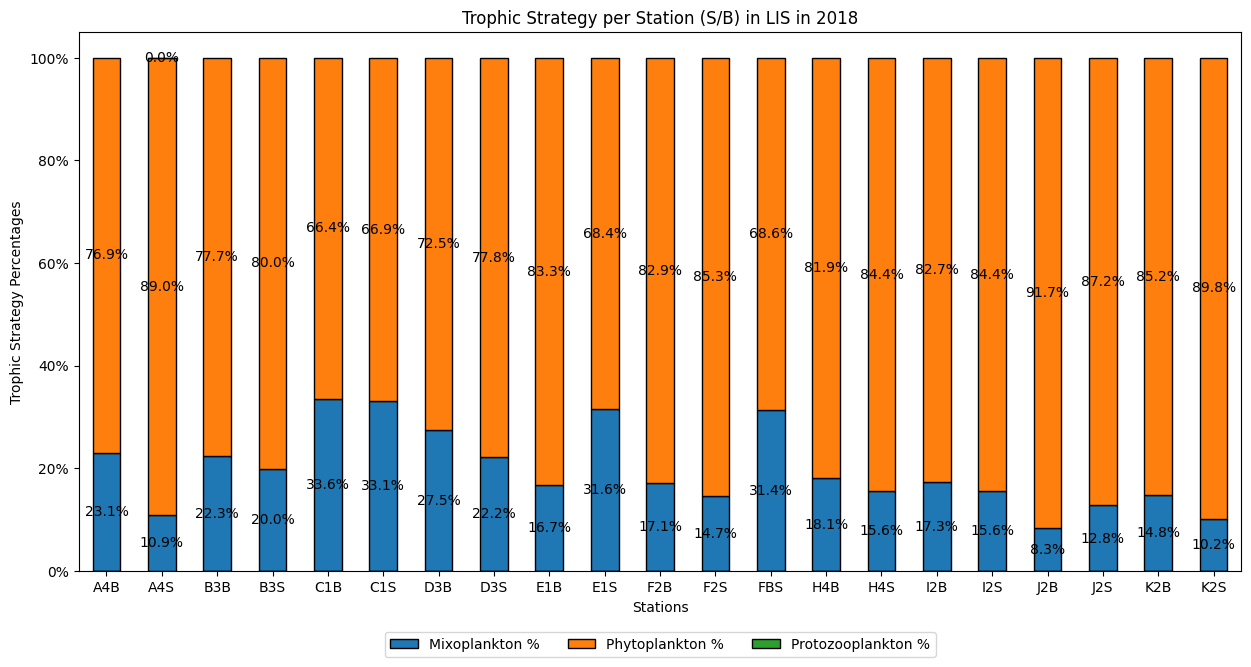

,Station,Mixoplankton,Phytoplankton,Protozooplankton,Totals,Mixoplankton %,Phytoplankton %,Protozooplankton %
0,A4B,1898468,6328696,0,8227164,23.075607,76.924393,0.000000
1,A4S,1399464,11402292,2904,12804660,10.929334,89.047987,0.022679
2,B3B,1009008,3509792,0,4518800,22.329114,77.670886,0.000000
3,B3S,2549184,10216360,0,12765544,19.969255,80.030745,0.000000
4,C1B,1247312,2464660,0,3711972,33.602409,66.397591,0.000000
5,C1S,2444024,4942674,0,7386698,33.086827,66.913173,0.000000
6,D3B,666424,1758548,0,2424972,27.481719,72.518281,0.000000
7,D3S,1141316,4003516,0,5144832,22.183737,77.816263,0.000000
8,E1B,354152,1766732,0,2120884,16.698320,83.301680,0.000000
9,E1S,1772408,3841420,0,5613828,31.572182,68.427818,0.000000


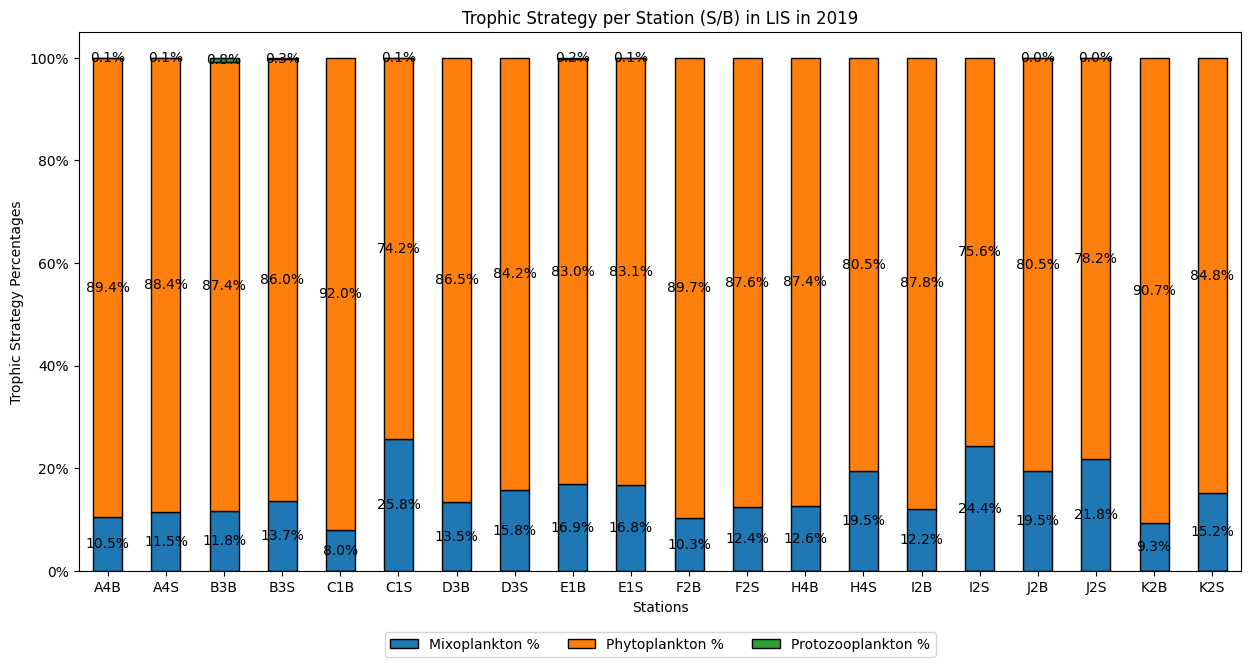

,Station,Mixoplankton,Phytoplankton,Protozooplankton,Totals,Mixoplankton %,Phytoplankton %,Protozooplankton %
0,A4B,976800,8324668,5852,9307320,10.494965,89.442160,0.062875
1,A4S,1338744,10284780,5852,11629376,11.511744,88.437935,0.050321
2,B3B,585068,4343196,39600,4967864,11.777053,87.425823,0.797123
3,B3S,1448920,9084372,29304,10562596,13.717461,86.005107,0.277432
4,C1B,467808,5355460,0,5823268,8.033427,91.966573,0.000000
5,C1S,1749704,5034920,3960,6788584,25.774212,74.167455,0.058333
6,D3B,902308,5803072,0,6705380,13.456478,86.543522,0.000000
7,D3S,1015080,5415520,0,6430600,15.785152,84.214848,0.000000
8,E1B,932008,4579916,8800,5520724,16.881989,82.958612,0.159399
9,E1S,667964,3301804,4400,3974168,16.807644,83.081641,0.110715


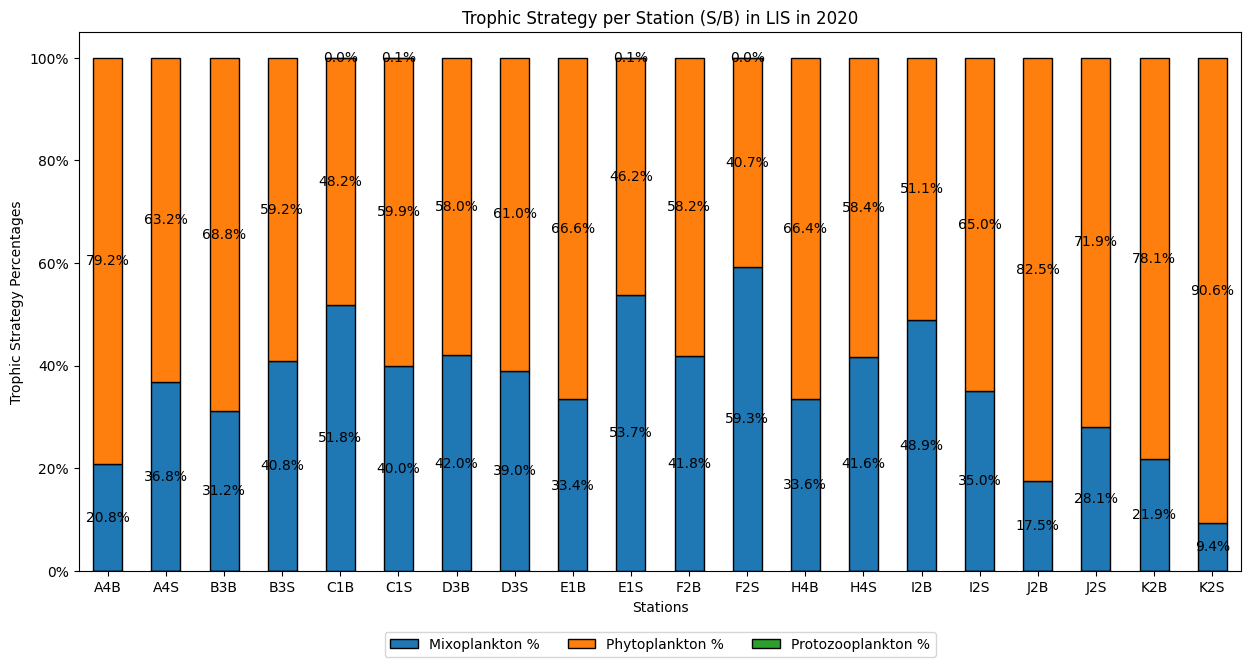

,Station,Mixoplankton,Phytoplankton,Protozooplankton,Totals,Mixoplankton %,Phytoplankton %,Protozooplankton %
0,A4B,193600,738012,0,931612,20.781184,79.218816,0.000000
1,A4S,1708828,2930268,0,4639096,36.835366,63.164634,0.000000
2,B3B,384252,849244,0,1233496,31.151459,68.848541,0.000000
3,B3S,1849760,2678984,0,4528744,40.844879,59.155121,0.000000
4,C1B,690800,642840,44,1333684,51.796378,48.200323,0.003299
5,C1S,1391060,2082344,2904,3476308,40.015442,59.901021,0.083537
6,D3B,551452,761288,0,1312740,42.007709,57.992291,0.000000
7,D3S,717156,1119756,0,1836912,39.041391,60.958609,0.000000
8,E1B,224444,446908,0,671352,33.431642,66.568358,0.000000
9,E1S,1847384,1588488,2904,3438776,53.722138,46.193413,0.084449


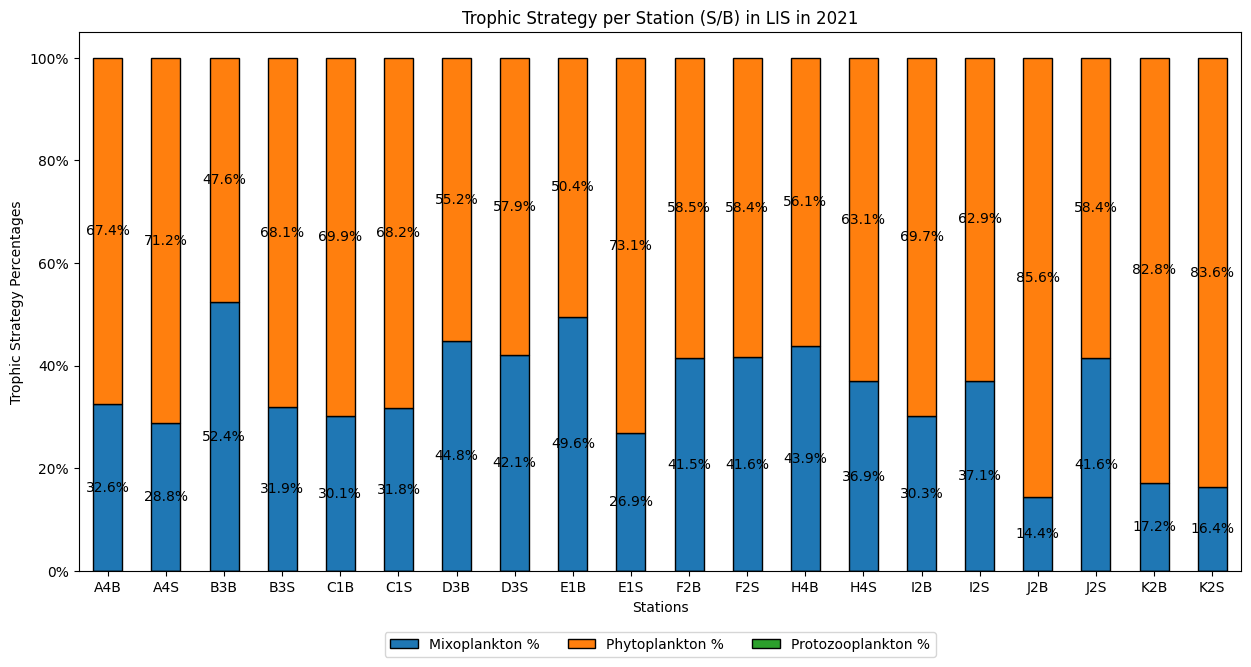

,Station,Mixoplankton,Phytoplankton,Protozooplankton,Totals,Mixoplankton %,Phytoplankton %,Protozooplankton %
0,A4B,867460,1795728,0,2663188,32.572240,67.427760,0.0
1,A4S,1906388,4704304,0,6610692,28.837949,71.162051,0.0
2,B3B,1293952,1174096,0,2468048,52.428154,47.571846,0.0
3,B3S,2325180,4954488,0,7279668,31.940742,68.059258,0.0
4,C1B,512204,1187780,0,1699984,30.129931,69.870069,0.0
5,C1S,1750672,3749416,0,5500088,31.829891,68.170109,0.0
6,D3B,727364,896940,0,1624304,44.780041,55.219959,0.0
7,D3S,806256,1109372,0,1915628,42.088339,57.911661,0.0
8,E1B,955108,972400,0,1927508,49.551442,50.448558,0.0
9,E1S,305360,827948,0,1133308,26.944132,73.055868,0.0


In [8]:
# Percentage of PLankton Trophic Strategy per Station
for csv_name in csvs:
    # Get pie chart for each year
    trophic_strategy_per_station(csv_name)

In [9]:
# Total cells/L per Plankton Trophic Strategy
def trophic_strategy_for_total_pie(csv_name):
    # Get year
    year = re.search(r'\b(\d{4})\b', csv_name).group(1) if re.search(r'\b(\d{4})\b', csv_name) else 'Year not found'
    
    # Clean Data
    classified = Classifier(csv_name)
    df = classified.all_classified
    df.loc[df['Genus']=='Protoperidinium', 'Status'] = 'Protozooplankton'
    df = df.replace(['No', 'Yes'], ['Phytoplankton', 'Mixoplankton'])
    df = df.replace('Yes', 'Mixoplankton')
    counts = percentages(df, 'Status')

    # Pie Chart
    plt.title(f"Total cells/L per Plankton Type in LIS in {year}")
    plt.pie(counts['Percentages'], labels=counts['Status'], autopct='%1.3f%%')
    plt.legend(bbox_to_anchor=(.2, 1))
    
    plt.show()
    display(counts)

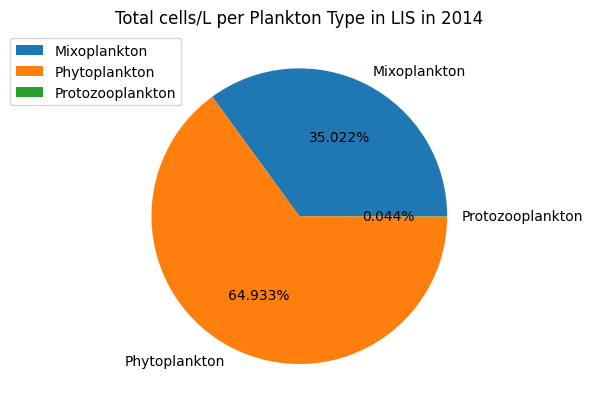

,Status,Totals,Percentages
0,Mixoplankton,30159886,35.022426
1,Phytoplankton,55917979,64.933378
2,Protozooplankton,38060,0.044196


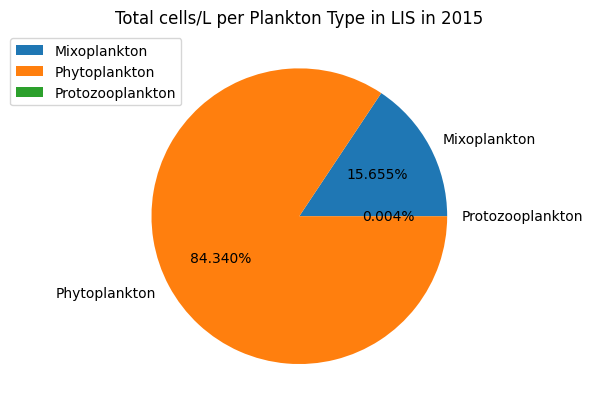

,Status,Totals,Percentages
0,Mixoplankton,21243460,15.655346
1,Phytoplankton,114445293,84.340341
2,Protozooplankton,5852,0.004313


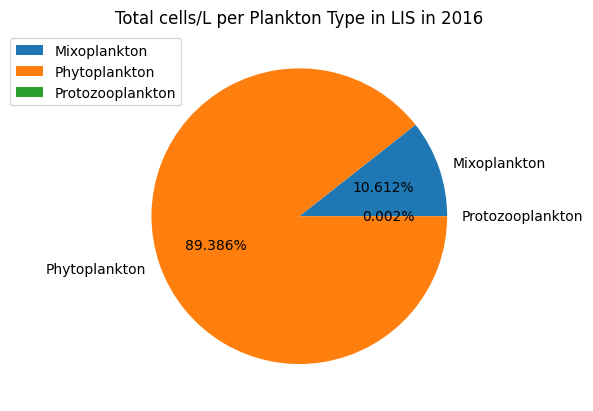

,Status,Totals,Percentages
0,Mixoplankton,8645340,10.612357
1,Phytoplankton,72818048,89.38586
2,Protozooplankton,1452,0.001782


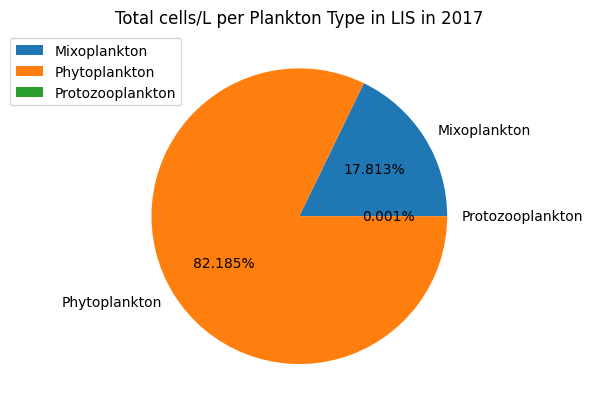

,Status,Totals,Percentages
0,Mixoplankton,18744098,17.813477
1,Phytoplankton,86478700,82.185143
2,Protozooplankton,1452,0.00138


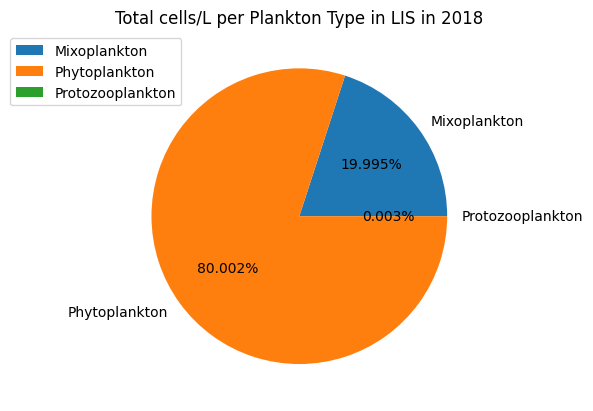

,Status,Totals,Percentages
0,Mixoplankton,18968748,19.994807
1,Phytoplankton,75896722,80.002132
2,Protozooplankton,2904,0.003061


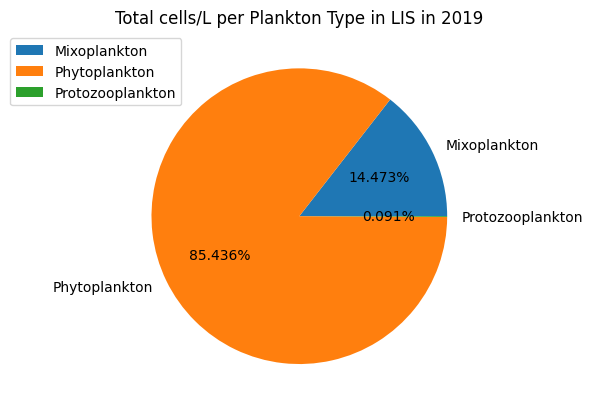

,Status,Totals,Percentages
0,Mixoplankton,15544320,14.472908
1,Phytoplankton,91760442,85.435735
2,Protozooplankton,98120,0.091357


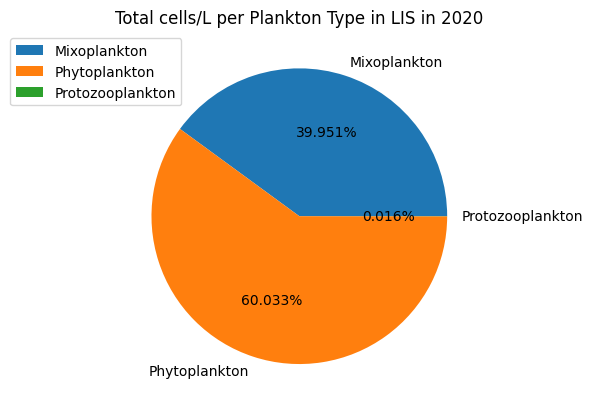

,Status,Totals,Percentages
0,Mixoplankton,15177844,39.951426
1,Phytoplankton,22806960,60.032939
2,Protozooplankton,5940,0.015635


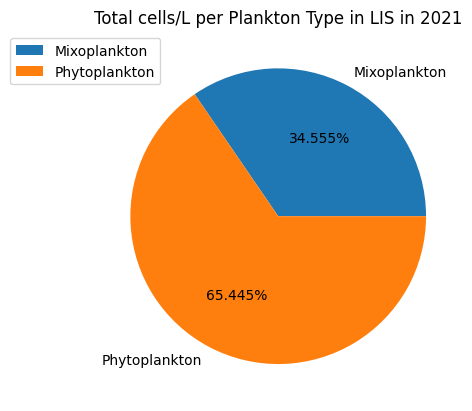

,Status,Totals,Percentages
0,Mixoplankton,17222656,34.554557
1,Phytoplankton,32619268,65.445443


In [10]:
# Percentage of PLankton Trophic Strategy per Station
for csv_name in csvs:
    # Get pie chart for each year
    trophic_strategy_for_total_pie(csv_name)

## 2. What different types of mixoplankton are present and what is their relative abundance?

In [11]:
def mixoplankton_type_pie(csv_name):
    # Get year
    year = re.search(r'\b(\d{4})\b', csv_name).group(1) if re.search(r'\b(\d{4})\b', csv_name) else 'Year not found'

    # Clean Data
    classified = Classifier(csv_name)
    df = classified.mixoplankton_with_header
    df = df.loc[:, ~df.columns.get_level_values(2).isin(['Status', 'Phylum', 'Genus', 'Species', 'Evidence of mixoplankton activity', 'size class', 'Totals'])]
    df.columns = df.columns.get_level_values(1)
    df = pd.concat([df[[np.nan]], df.groupby(df.columns.str[0], axis=1).sum()], axis=1).rename(columns= {np.nan:'MFT'}).groupby('MFT').sum().reset_index()
    df['Totals'] = df.iloc[:, 1:].sum(axis=1)
    df = df[df['Totals'] != 0]
    df['Percentages'] = ((df['Totals'] / df['Totals'].sum()) * 100)

    # Pie Chart
    plt.title(f"Mixoplankton Functional Type in LIS in {year}")
    plt.pie(df['Percentages'], labels=df['MFT'], autopct='%1.3f%%')
    plt.legend(bbox_to_anchor=(.2, 1))
    
    plt.show()
    display(df)

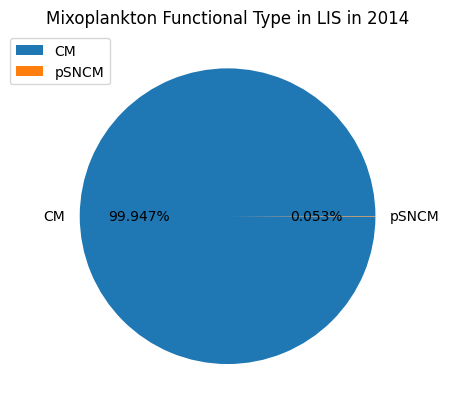

,MFT,A,B,C,D,E,F,H,I,J,K,Totals,Percentages
0,CM,5844292,4432120,3338016,3766312,2747844,1862432,3319982,1829652,1758372,1244804,30143826,99.94675
2,pSNCM,2904,4400,4400,0,0,2904,0,1452,0,0,16060,0.05325


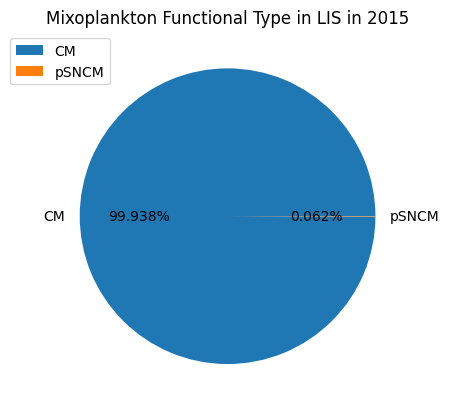

,MFT,A,B,C,D,E,F,H,I,J,K,Totals,Percentages
0,CM,2735304,3808464,2933612,2466772,1778744,3059408,1440600,1224740,1133044,649616,21230304,99.93807
2,pSNCM,0,5852,5852,0,1452,0,0,0,0,0,13156,0.06193


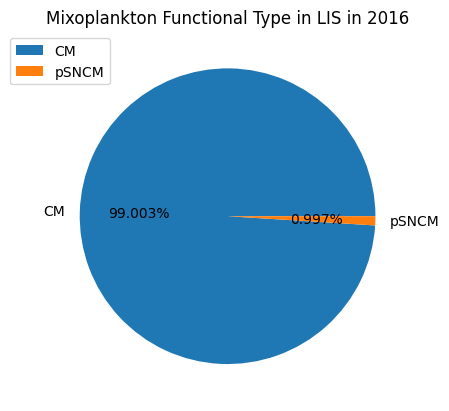

,MFT,A,B,C,D,E,F,H,I,J,K,Totals,Percentages
0,CM,1458512,1270060,1249512,1378476,263868,649660,542564,1243616,265408,237468,8559144,99.002977
2,pSNCM,11704,17512,10208,5808,11704,14652,2904,10252,1452,0,86196,0.997023


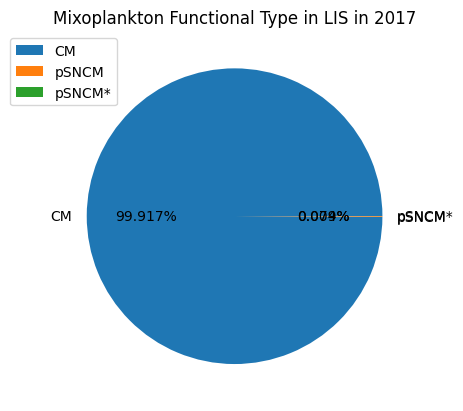

,MFT,A,B,C,D,E,F,H,I,J,K,Totals,Percentages
0,CM,3525764,4267120,2090660,1998964,1930720,962016,1261964,1113034,1117424,460944,18728610,99.917371
2,pSNCM,1452,2156,5060,1452,1452,0,0,2156,1056,0,14784,0.078873
3,pSNCM*,0,0,0,0,704,0,0,0,0,0,704,0.003756


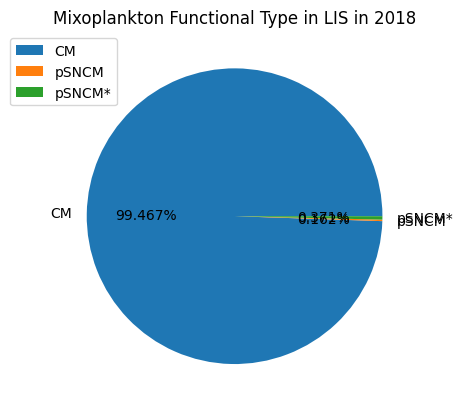

,MFT,A,B,C,D,E,F,H,I,J,K,Totals,Percentages
0,CM,3296524,3553176,3687024,1734876,2125108,1332496,1096920,1110824,485760,444972,18867680,99.467187
2,pSNCM,1408,5016,4312,2464,1452,13904,704,704,352,352,30668,0.161676
3,pSNCM*,0,0,0,70400,0,0,0,0,0,0,70400,0.371137


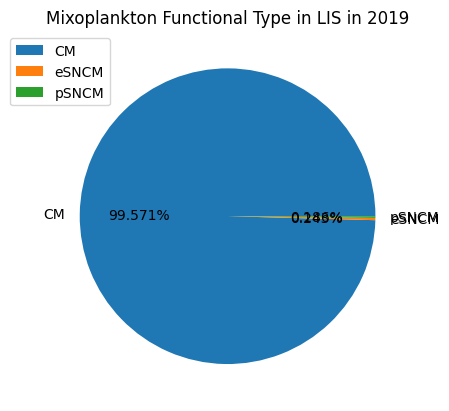

,MFT,A,B,C,D,E,F,H,I,J,K,Totals,Percentages
0,CM,2311760,2020788,2215576,1917212,1598520,1304380,1403116,1335884,958540,411840,15477616,99.570879
1,eSNCM,0,0,0,0,0,0,30800,792,6028,176,37796,0.243150
2,pSNCM,3784,13200,1936,176,1452,6204,352,1804,0,0,28908,0.185971


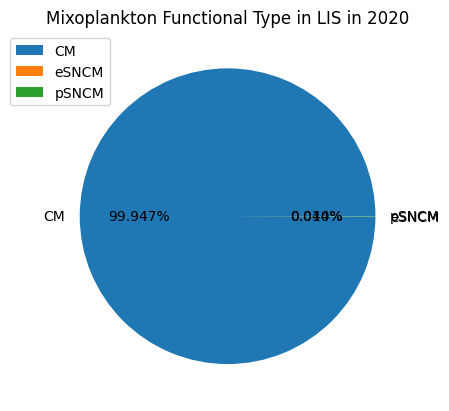

,MFT,A,B,C,D,E,F,H,I,J,K,Totals,Percentages
0,CM,1902428,2233836,2078956,1265704,2071740,1883552,1648812,1425644,428824,230252,15169748,99.946659
1,eSNCM,0,0,0,0,0,0,0,0,0,1452,1452,0.009567
2,pSNCM,0,176,2904,2904,88,0,176,176,88,132,6644,0.043774


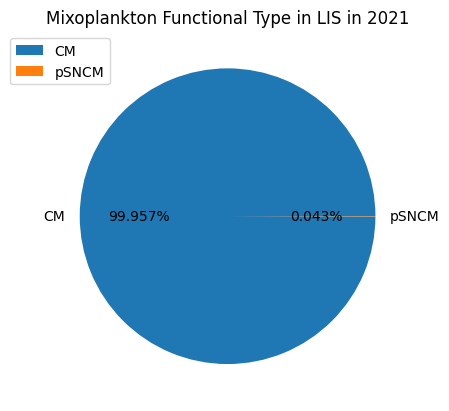

,MFT,A,B,C,D,E,F,H,I,J,K,Totals,Percentages
0,CM,2773056,3616976,2259972,1532564,1260468,1545720,1485616,1195920,1192136,352792,17215220,99.956824
2,pSNCM,792,2156,2904,1056,0,352,0,0,88,88,7436,0.043176


In [12]:
for csv_name in csvs:
    # Get pie chart for each year
    mixoplankton_type_pie(csv_name)

## 3. For just the dinoflagellates, what fraction are phyto vs mixo vs heterotrophs?  
### All of the dinoflagellates that are in the genus Protoperidinium are strict heterotrophs. They only use phagocytosis for nutrition and are not capable of photosynthesis. They get counted in these kinds of monitoring programs just because the person doing the counting sees them but they are not phytoplankton at all.

In [14]:
def trophic_strategy_for_dinoflagellates_pie(csv_name):
    # Get year
    year = re.search(r'\b(\d{4})\b', csv_name).group(1) if re.search(r'\b(\d{4})\b', csv_name) else 'Year not found'

    # Clean Data
    classified = Classifier(csv_name)
    df = classified.all_classified
    df = df.loc[df['Phylum'] == 'Dinoflagellate']
    df.loc[df['Genus']=='Protoperidinium', 'Status'] = 'Protozooplankton'
    df = df.replace('No', 'Phytoplankton')
    df = df.replace('Yes', 'Mixoplankton')
    counts = percentages(df, 'Status')
    
    # Pie Chart
    plt.title(f"Trophic Strategy of Dinoflagellates in LIS in {year}")
    plt.pie(counts['Percentages'], labels=counts['Status'], autopct='%1.3f%%')
    plt.legend(bbox_to_anchor=(.2, 1))
    
    plt.show()
    display(counts)

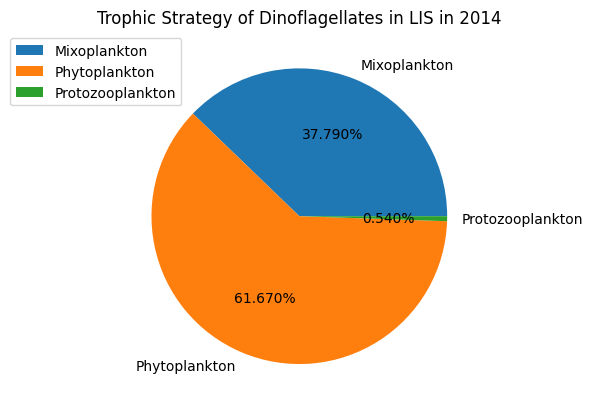

,Status,Totals,Percentages
0,Mixoplankton,2663104,37.790295
1,Phytoplankton,4345894,61.669622
2,Protozooplankton,38060,0.540084


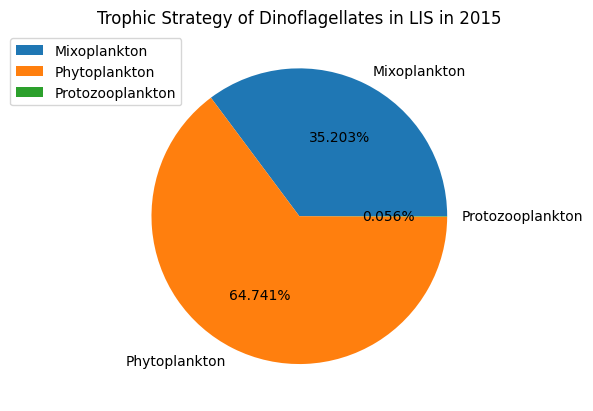

,Status,Totals,Percentages
0,Mixoplankton,3659608,35.202836
1,Phytoplankton,6730316,64.740872
2,Protozooplankton,5852,0.056292


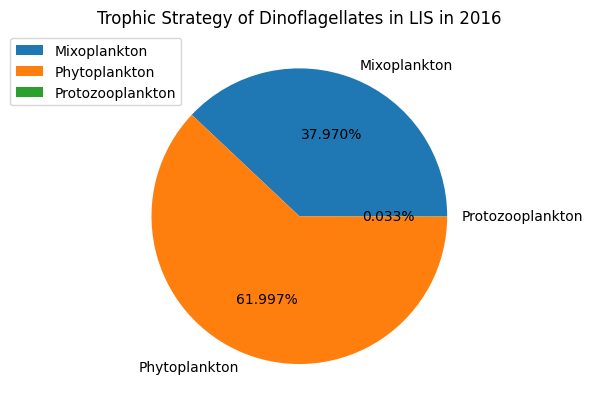

,Status,Totals,Percentages
0,Mixoplankton,1666984,37.969914
1,Phytoplankton,2721840,61.997013
2,Protozooplankton,1452,0.033073


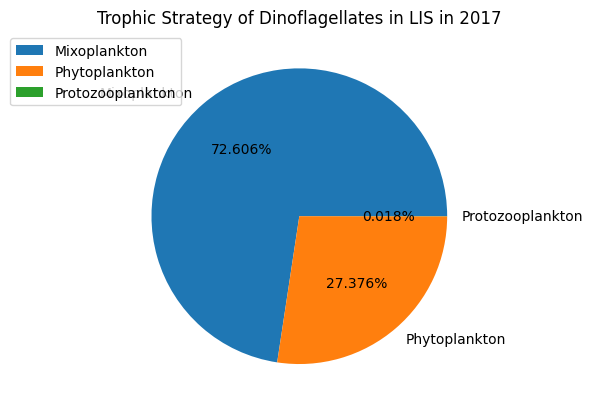

,Status,Totals,Percentages
0,Mixoplankton,5965212,72.606092
1,Phytoplankton,2249192,27.376234
2,Protozooplankton,1452,0.017673


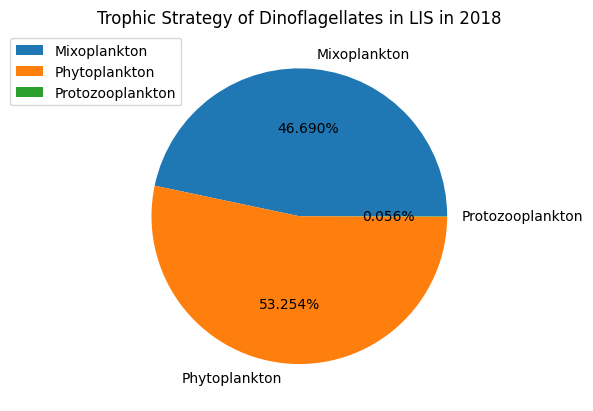

,Status,Totals,Percentages
0,Mixoplankton,2429984,46.689734
1,Phytoplankton,2771648,53.254469
2,Protozooplankton,2904,0.055797


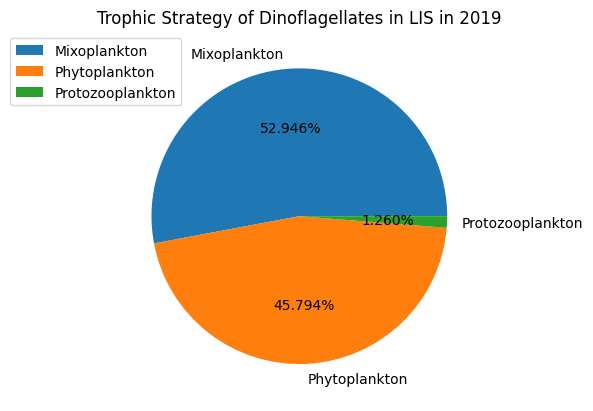

,Status,Totals,Percentages
0,Mixoplankton,4122976,52.946218
1,Phytoplankton,3566006,45.79375
2,Protozooplankton,98120,1.260032


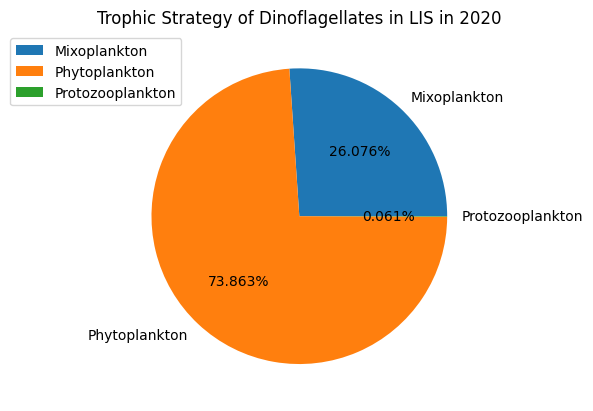

,Status,Totals,Percentages
0,Mixoplankton,2522476,26.075941
1,Phytoplankton,7145160,73.862654
2,Protozooplankton,5940,0.061404


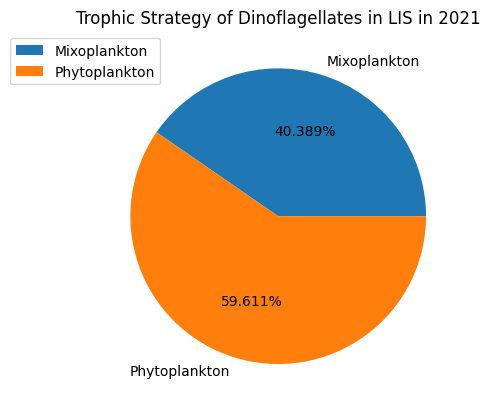

,Status,Totals,Percentages
0,Mixoplankton,1538592,40.38948
1,Phytoplankton,2270796,59.61052


In [15]:
for csv_name in csvs:
    # Get pie chart for each year
    trophic_strategy_for_dinoflagellates_pie(csv_name)

## 4. What fraction of mixoplankton are nano size and micro size?

In [16]:
def mixoplankton_sizes_pie(csv_name):
    # Get year
    year = re.search(r'\b(\d{4})\b', csv_name).group(1) if re.search(r'\b(\d{4})\b', csv_name) else 'Year not found'

    # Clean data
    classified = Classifier(csv_name)
    df = classified.mixoplankton
    counts = percentages(df, 'size class')
    
    # Pie Chart
    plt.title(f"Relative Size of Mixoplankton in LIS in {year}")
    plt.pie(counts['Percentages'], labels=counts['size class'], autopct='%1.3f%%')
    plt.legend(bbox_to_anchor=(.2, 1))
    
    plt.show()
    display(counts)

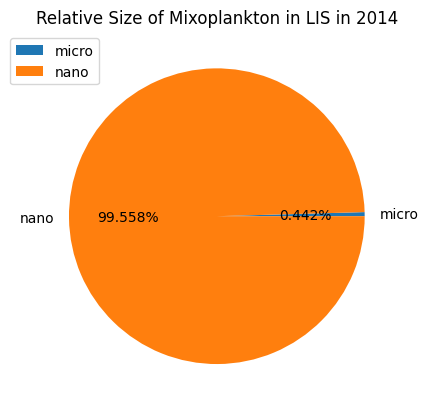

,size class,Totals,Percentages
1,micro,133320,0.442044
2,nano,30026566,99.557956


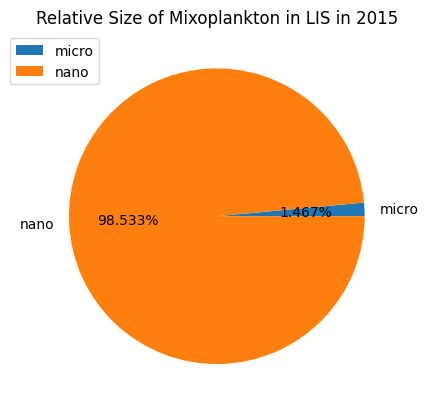

,size class,Totals,Percentages
1,micro,311564,1.466635
2,nano,20931896,98.533365


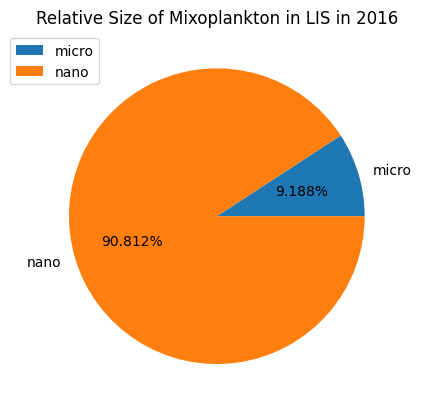

,size class,Totals,Percentages
1,micro,794376,9.188488
2,nano,7850964,90.811512


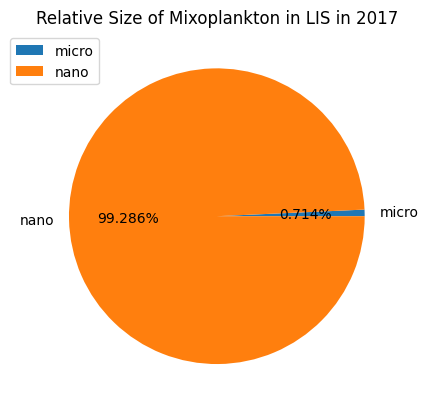

,size class,Totals,Percentages
1,micro,133760,0.713611
2,nano,18610338,99.286389


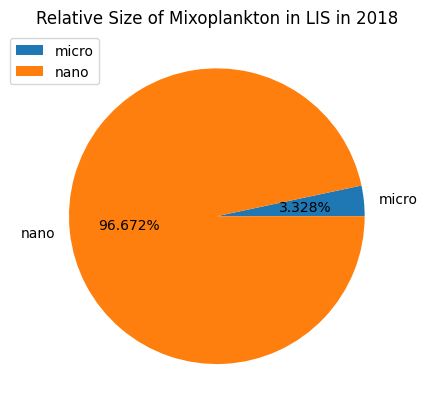

,size class,Totals,Percentages
1,micro,631312,3.328169
2,nano,18337436,96.671831


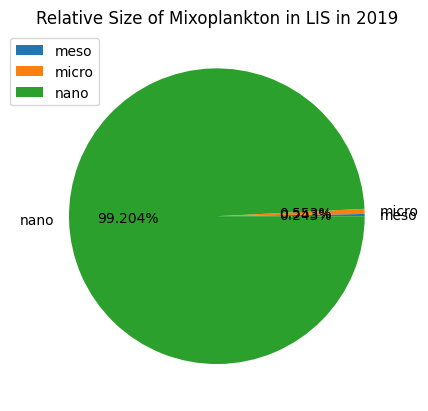

,size class,Totals,Percentages
0,meso,37796,0.24315
1,micro,85976,0.553102
2,nano,15420548,99.203748


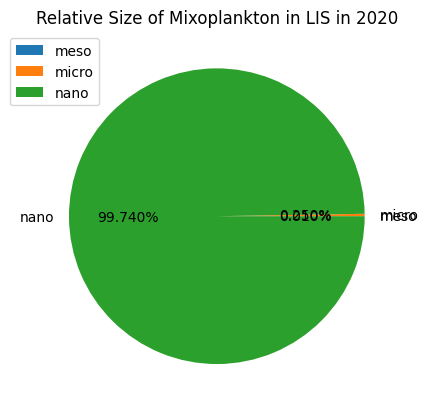

,size class,Totals,Percentages
0,meso,1452,0.009567
1,micro,37972,0.25018
2,nano,15138420,99.740253


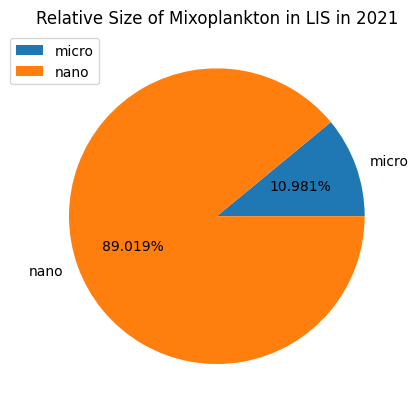

,size class,Totals,Percentages
1,micro,1891252,10.981187
2,nano,15331404,89.018813


In [17]:
for csv_name in csvs:
    # Get pie chart for each year
    mixoplankton_sizes_pie(csv_name)

## 5. What proportion of the mixoplankton are dinoflagellates?

In [18]:
def mixoplankton_phylums_pie(csv_name):
    # Get year
    year = re.search(r'\b(\d{4})\b', csv_name).group(1) if re.search(r'\b(\d{4})\b', csv_name) else 'Year not found'

    # Clean data
    classified = Classifier(csv_name)
    df = classified.mixoplankton
    counts = percentages(df, 'Phylum')
    
    # Pie Chart
    plt.title(f"Relative Abundance of Mixoplankton Phylum in LIS in {year}")
    plt.pie(counts['Percentages'], labels=counts['Phylum'], autopct='%1.3f%%')
    plt.legend(bbox_to_anchor=(.19, 1))
    
    plt.show()
    display(counts)

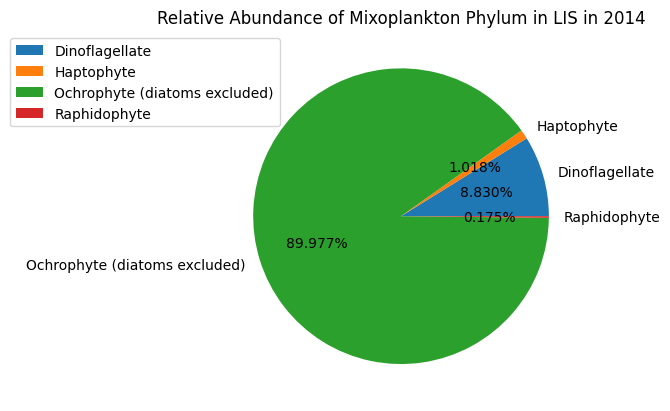

,Phylum,Totals,Percentages
0,Dinoflagellate,2663104,8.829954
1,Haptophyte,307089,1.018203
2,Ochrophyte (diatoms excluded),27136849,89.97663
3,Raphidophyte,52844,0.175213


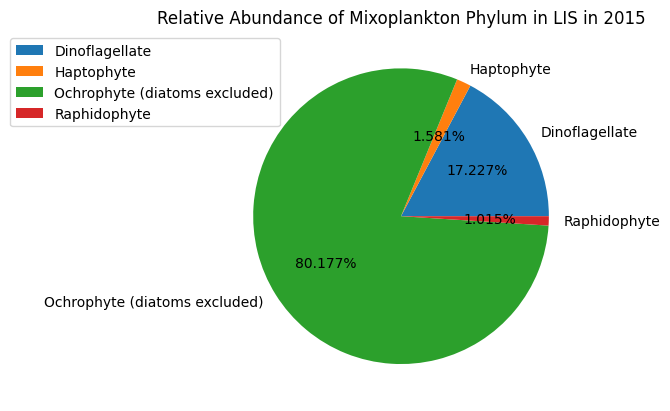

,Phylum,Totals,Percentages
0,Dinoflagellate,3659608,17.226987
1,Haptophyte,335852,1.580967
2,Ochrophyte (diatoms excluded),17032400,80.177146
3,Raphidophyte,215600,1.014901


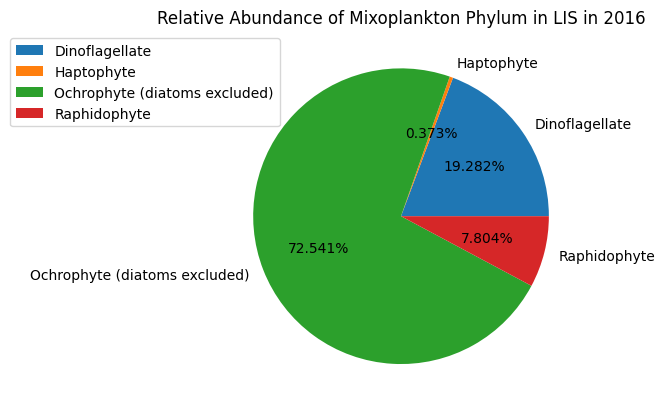

,Phylum,Totals,Percentages
0,Dinoflagellate,1666984,19.281879
1,Haptophyte,32252,0.373056
2,Ochrophyte (diatoms excluded),6271452,72.541415
3,Raphidophyte,674652,7.803649


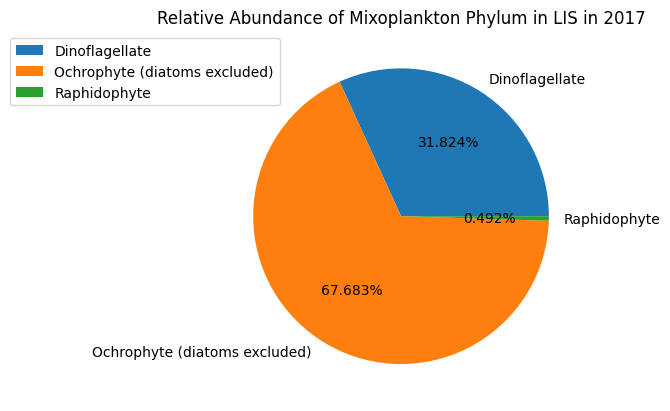

,Phylum,Totals,Percentages
0,Dinoflagellate,5965212,31.824481
2,Ochrophyte (diatoms excluded),12686618,67.683268
3,Raphidophyte,92268,0.492251


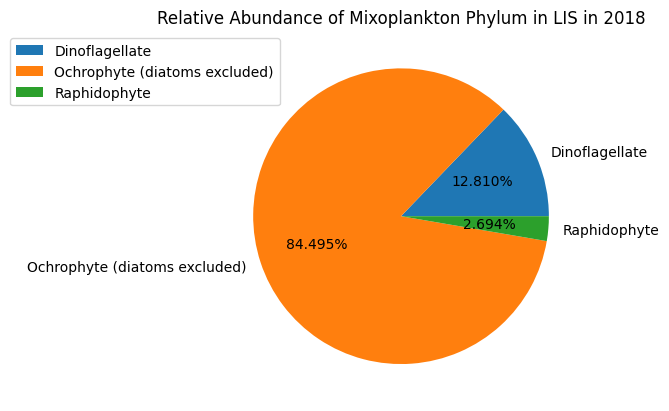

,Phylum,Totals,Percentages
0,Dinoflagellate,2429984,12.810461
2,Ochrophyte (diatoms excluded),16027660,84.495086
3,Raphidophyte,511104,2.694453


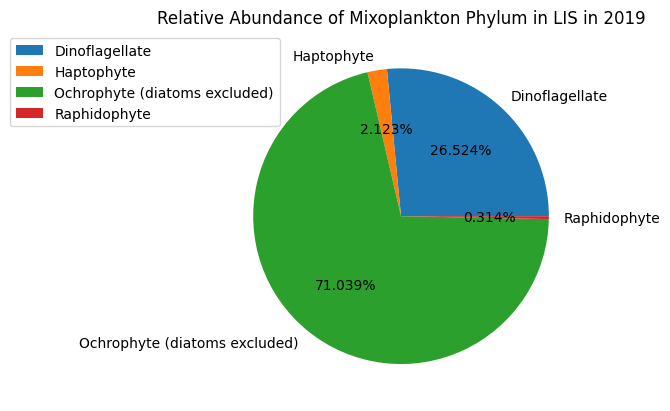

,Phylum,Totals,Percentages
0,Dinoflagellate,4122976,26.524004
1,Haptophyte,330000,2.122962
2,Ochrophyte (diatoms excluded),11042460,71.038553
3,Raphidophyte,48884,0.314481


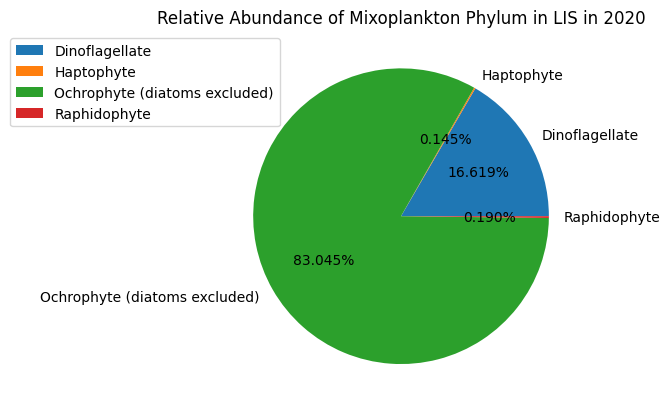

,Phylum,Totals,Percentages
0,Dinoflagellate,2522476,16.619462
1,Haptophyte,22000,0.144948
2,Ochrophyte (diatoms excluded),12604504,83.045418
3,Raphidophyte,28864,0.190172


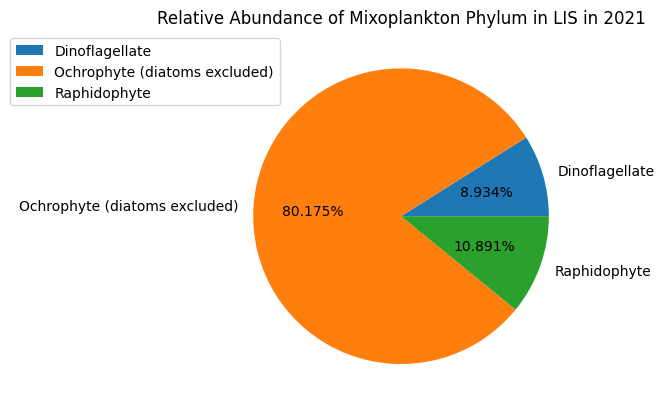

,Phylum,Totals,Percentages
0,Dinoflagellate,1538592,8.933535
2,Ochrophyte (diatoms excluded),13808344,80.175462
3,Raphidophyte,1875720,10.891003


In [19]:
for csv_name in csvs:
    # Get pie chart for each year
    mixoplankton_phylums_pie(csv_name)